# Digit recognition
## Imports:


In [21]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Module's style
np.random.seed(2)
sns.set(style='white', context='notebook', palette='deep')


## Load the data


In [24]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

# Define X and y train
X_train = train.drop('label', axis=1)
y_train = train['label']


## Show the count of each y value


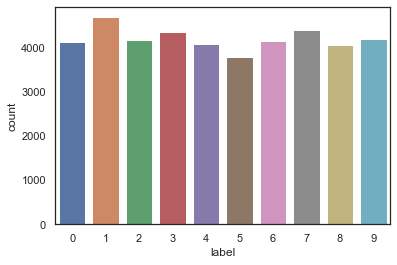

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


In [25]:
count_of_each_y_value = sns.countplot(y_train)
plt.show()

print(y_train.value_counts())


## Look for NaN


In [14]:
print(X_train.isnull().sum().sum())
print(y_train.isnull().sum().sum())
print(test.isnull().sum().sum())


0
0
0


## Normalize Greyscale

We perform a grayscale normalization to reduce the effect of illumination's differences.
Moreover the CNN converg faster on [0..1] data than on [0..255].


In [3]:
X_train = X_train / 255.0
test = test / 255.0


## Reshape image
Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)


In [4]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)


## Label Encodging
Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [5]:
y_train = to_categorical(y_train, num_classes = 10)



## Split train set


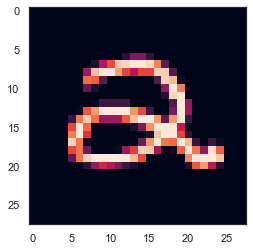

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state=2)

plt.imshow(X_train[12][:,:,0])


## Set the CNN model 
My CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out


In [7]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))



W0724 12:25:47.690634 4632413632 deprecation_wrapper.py:119] From /Users/maxim/.local/share/virtualenvs/digit_recognition-iZl3B25-/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 12:25:47.714295 4632413632 deprecation_wrapper.py:119] From /Users/maxim/.local/share/virtualenvs/digit_recognition-iZl3B25-/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 12:25:47.720063 4632413632 deprecation_wrapper.py:119] From /Users/maxim/.local/share/virtualenvs/digit_recognition-iZl3B25-/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 12:25:47.765315 4632413632 deprecation_wrapper.py:119] From /Users/maxim/.local/share/virtualenvs/digit_recognition-iZl3B25-/lib/py

## Optimizer


In [8]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# epochs = The number of "itteration" of the learning phase
epochs = 30 # Turn epochs to 30 best accuracy
batch_size = 86


W0724 12:25:51.802053 4632413632 deprecation_wrapper.py:119] From /Users/maxim/.local/share/virtualenvs/digit_recognition-iZl3B25-/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 12:25:51.813489 4632413632 deprecation_wrapper.py:119] From /Users/maxim/.local/share/virtualenvs/digit_recognition-iZl3B25-/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



## improve the train dataset
### Data augmentation:
If i let the dataset like this i'll have 98% accuracy. But if i want to improve it,
 I need to add datas. I can do it with **data augmentation**.
**data augmentation** will create news images with the existing ones and rotate them,
zoom on it, change the colors,...
With this technique I can easly double or triple the original dataset.

### In this case:
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify
 symetrical numbers such as 6 and 9.
 
- Randomly rotate some training images by 10 degrees
- Randomly Zoom by 10% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height


In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


## Fit the model


In [10]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


W0724 12:25:59.668691 4632413632 deprecation.py:323] From /Users/maxim/.local/share/virtualenvs/digit_recognition-iZl3B25-/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
 - 88s - loss: 0.4120 - acc: 0.8686 - val_loss: 0.0821 - val_acc: 0.9748
Epoch 2/2
 - 81s - loss: 0.1277 - acc: 0.9619 - val_loss: 0.0482 - val_acc: 0.9845


## Evaluate the model

### Plot the loss and accuracy curves for training and validation 


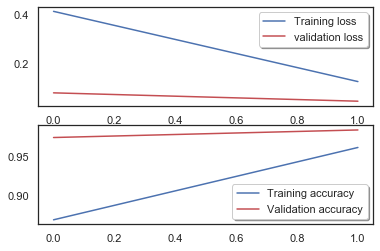

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


### Confusion matrix


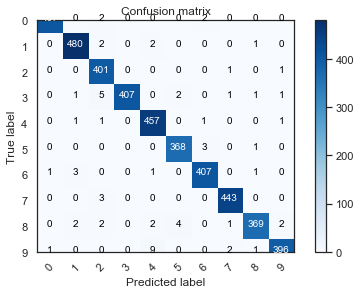

In [12]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


## predict results


In [17]:
results = model.predict(test)

# select the indice with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")


## Save predictions


In [20]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("results_predicted.csv",index=False)
